In [1]:
%matplotlib inline

In [2]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models

In [3]:
device = torch.device('cuda:1')

In [4]:
!mkdir -p style_images/
!wget https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg -O style_images/picasso.jpg
!wget https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg -O style_images/dancing.jpg

--2019-01-29 15:42:34--  https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114573 (112K) [image/jpeg]
Saving to: ‘style_images/picasso.jpg’

style_images/picass 100%[===================>] 111,89K   386KB/s    in 0,3s    

2019-01-29 15:42:35 (386 KB/s) - ‘style_images/picasso.jpg’ saved [114573/114573]

--2019-01-29 15:42:35--  https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg
Resolving pytorch.org (pytorch.org)... 185.199.108.153
Connecting to pytorch.org (pytorch.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40484 (40K) [image/jpeg]
Saving to: ‘style_images/dancing.jpg’

style_images/dancin 100%[===================>]  39,54K   124KB/s    in 0,3s    

2019-01-29 15:42:36 (124 KB/s) - ‘style_images/dancing.jpg’ saved [4048

In [5]:
!ls style_images/

dancing.jpg  picasso.jpg


In [6]:
imsize = 512

In [7]:
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

In [8]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [9]:
style_img = image_loader('style_images/picasso.jpg')
content_img = image_loader('style_images/dancing.jpg')
assert style_img.size() == content_img.size()

In [10]:
unloader = transforms.ToPILImage()

In [11]:
plt.ion()

In [12]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

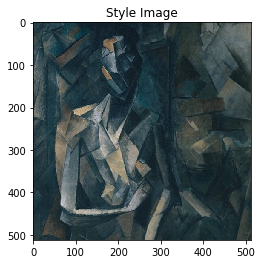

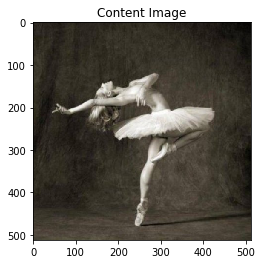

In [13]:
plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [76]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    
    def forward(self, x):
        self.loss = F.mse_loss(x, self.target)
        return x

In [77]:
def gram_matrix(x):
    a, b, c, d = x.size()
    features = x.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [78]:
class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super().__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, x):
        G = gram_matrix(x)
        self.loss = F.mse_loss(G, self.target)
        return x

In [79]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [80]:
mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [81]:
class Normalization(nn.Module):

    def __init__(self, mean, std):
        super().__init__()
        # reshape to directly subtract/divide each channel
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def forward(self, img):
        return (img - self.mean)/self.std

In [82]:
content_layers_default = ('conv_4',)
style_layers_default = tuple(f'conv_{i}' for i in range(1, 6))

In [88]:
def get_style_model_and_losses(cnn, norm_mean, norm_std, 
                               style_img, content_img, 
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)
    norm = Normalization(norm_mean, norm_std).to(device)

    content_losses = []
    style_losses = []
    
    model = nn.Sequential(norm)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError(f'unrecognized layer: {layer.__class__.__name__}')
            
        print(i, name)
    
        model.add_module(name, layer)
        
        if name in content_layers:
            breakpoint()
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f'content_loss_{i}', content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module('style_loss_{i}', style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], (ContentLoss, StyleLoss)):
            break
    
    model = model[:(i + 1)]
    
    return model, style_losses, content_losses

In [89]:
input_img = content_img.clone()

In [90]:
def get_input_optimizer(input_img):
    return optim.LBFGS([input_img.requires_grad_()])

In [91]:
def run_style_transfer(cnn, norm_mean, norm_std, content_img, style_img, input_img, 
                       num_steps=300, style_weight=1000000, content_weight=1):
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(
        cnn, norm_mean, norm_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
                
            style_score *= style_weight
            content_score *= content_weight
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print(f'run {run}')
                print(f'Style Loss: {style_score.item():4f} '
                      f'Content Loss: {content_style.item():4f}')
            
            return style_score + content_score
        
        optimizer.step(closure)
        
    input_img.data.clamp_(0, 1)
    
    return input_img            

In [92]:
output = run_style_transfer(cnn, mean, std, content_img, style_img, input_img)

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Building the style transfer model..
1 conv_1
1 relu_1
2 conv_2
2 relu_2
2 pool_2
3 conv_3
3 relu_3
4 conv_4
> <ipython-input-88-b70130e432fa>(34)get_style_model_and_losses()
-> target = model(content_img).detach()
(Pdb) content_img.shape
torch.Size([1, 3, 512, 512])
(Pdb) model
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_{i}): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
(Pdb) model(content_img)
*** RuntimeError: The size of tensor a (64) must match the size of tensor b (128) at non-singleton dimension 1
(Pdb) exit


BdbQuit: 